# Backtesting of predctions

## Author: Danilo Filippo Reiszel Pereira
Univesidade Federal do Rio de Janeiro

This notebook contains the creation a Multi-layer Perceptron model to predict D+1 closing prices of PETR4 stocks, using as input 10 delays of its return series and some auxiliary series, with backtesting of the predictions

In [26]:
from __future__ import print_function, division
import sys, os
sys.path.append('../../../../src')
import time 
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuralstocks.dataacquisition import *
from neuralstocks.plots import *

%matplotlib inline

# Global Params
Setting global params and useful variables, such as directories and image styling

In [7]:
saveVarDir = './Variables'
os.makedirs(saveVarDir) if not os.path.exists(saveVarDir) else print('', end='\r')

saveFigDir = './Figures'
os.makedirs(saveFigDir) if not os.path.exists(saveFigDir) else print('', end='\r')

saveModelDir = './Models'
os.makedirs(saveModelDir) if not os.path.exists(saveModelDir) else print('', end='\r')

pathAsset = '{}/PETR4_MLP_predicted.CSV'.format(saveVarDir)

plt.rcParams['font.weight'] = 'bold'
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16

## Data Acquisition

In [139]:
init_time = time.time()

df = pd.read_csv(pathAsset, parse_dates=['Date'], index_col='Date')
df = df.sort_index()

end_time = time.time()
print('Time to acquire and process data: '+str(end_time-init_time)+' seconds')

Time to acquire and process data: 0.0749309062958 seconds


In [140]:
df.columns

Index([u'PETR4_Close', u'PETR4_Open', u'PETR4_High', u'PETR4_Low',
       u'PETR4_Volume', u'PETR4_Quantity', u'PETR4_Holiday',
       u'PETR4_Close_rollMean20', u'PETR4_Close_rollStd20',
       u'PETR4_Close_EMA17', u'PETR4_Close_EMA17_logdiff',
       u'PETR4_Close_EMA72', u'PETR4_Close_EMA72_logdiff',
       u'PETR4_Close_EMA200', u'PETR4_Close_EMA200_logdiff',
       u'PETR4_Volume_EMA21', u'PETR4_Volume_EMA21_logdiff',
       u'PETR4_MACD_12_26_9', u'PETR4_MACDsignal_12_26_9',
       u'PETR4_MACDdiff_12_26_9', u'PETR4_BollingerMA_20',
       u'PETR4_BollingerUpper_20', u'PETR4_BollingerLower_20',
       u'PETR4_Bollinger%b_20', u'PETR4_OBV', u'PETR4_Close_returns',
       u'PETR4_Close/Open_returns', u'PETR4_High/Close_returns',
       u'PETR4_Low/Close_returns', u'PETR4_Close_trend', u'PETR4_Close_resid',
       u'IBOV_Close', u'IBOV_Open', u'IBOV_High', u'IBOV_Low', u'IBOV_Volume',
       u'IBOV_Quantity', u'IBOV_Holiday', u'IBOV_Close_rollMean20',
       u'IBOV_Close_rollStd20'

In [128]:
from __future__ import division
import random
from collections import defaultdict
from datetime import timedelta

class Backtest:
    dailyData = {}
    history = {}
    verbose = 0;
    shortedFunds = 0
    pendingOperations = []
    openPositions = []
    strategy = ''
    predictedValues = {}
    oneDay = timedelta(days = 1)
    
    useRiskManagement = False
    stopLoss = None
    stopGain = None
    maxExposure = None
    maxTotalExposure = None
    
    def __init__(self, assets, dataPath = '../../../data/stocks/[asset]/diario/[asset].CSV', initialFunds = 100000, 
                 brokerage = 6.0, transactionFees = 0.000325, ISStax = 0.05):
        self.assets = assets
        self.dataPath = dataPath
        self.funds = initialFunds
        self.brokerage = brokerage
        self.transactionFees = transactionFees
        self.ISStax = ISStax
        
        self.loadData()
        
    def setRiskManagement(self, stopLoss = None, stopGain = None, maxExposure = None, maxTotalExposure = None, useRiskManagement = True):
        self.useRiskManagement = useRiskManagement
        self.stopLoss = stopLoss
        self.stopGain = stopGain
        self.maxExposure = maxExposure
        self.maxTotalExposure = maxTotalExposure
        
    def loadData(self):
        for asset in self.assets:
            filePath = self.dataPath.replace('[asset]', asset)
            df = pd.read_csv(filePath, delimiter=';', decimal=',',
                     parse_dates=['Date'], dayfirst=True, index_col='Date').sort_index()
            self.dailyData[asset] = df
    
    def simulate(self, funds = None, strategy = 'buy-n-hold', start = None, end = None, longOnly = False, predicted = None, simulationName = None, verbose = 0):
        simulationName = simulationName if simulationName else strategy
        self.strategy = strategy
        self.funds = funds if funds else self.funds
        self.verbose = verbose
        if strategy == 'buy-n-hold':
            self.buyNHold(start, end)
        elif strategy == 'repeatLast':
            pass
        elif strategy == 'predicted':
            if predicted:
                for asset in self.assets:
                    if not predicted[asset].any():
                        print('Warning: No predictions for {}. This asset will be excluded from the simulation.'.format(asset))
                    else:
                        self.predictedValues[asset] = predicted[asset]
            if self.predictedValues:
                self.simulatePredicted(start, end, simulationName)
            else:
                print('No predicted values given for the selected assets')
            self.predictedValues = {}
        else:
            print('Selected strategy not recognized')
    
    def buyNHold(self, start, end):
        self.history['buy-n-hold'] = pd.DataFrame(index=self.dailyData[self.assets[0]][start:end].index, columns=['portfolioValue'])
        maxValue = self.funds / len(self.assets)
        random.shuffle(self.assets)
        date = self.dailyData[self.assets[0]][start:end].index[0]
        print('Portfolio value at start: {:.2f} BRL'.format(self.funds))
        previousPortfolioValue = self.funds
        #buy all
        for asset in self.assets:
            self.buy(asset = asset, date = self.dailyData[asset][start:end].index[0], limitValue = maxValue)
        #evaluate portfolio value for each trading day
        for d in self.dailyData[self.assets[0]][start:end].index:
            date = d
            self.history['buy-n-hold'].at[date, 'portfolioValue'] = self.evaluatePortfolio(date)
            if self.verbose >= 1:
                print('Portfolio value at {} market close: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), self.history['buy-n-hold']['portfolioValue'][date]))
        #sell all
        self.liquidateAll(date)
        print('Portfolio value at end: {:.2f} BRL'.format(self.funds))
        self.calculateDrawdown('buy-n-hold')
        
    def simulatePredicted(self, start, end, simulationName = 'predicted'):
        self.history[simulationName] = pd.DataFrame(index=self.dailyData[self.assets[0]][start:end].index, columns=['portfolioValue'])
        maxValue = self.funds / len(self.assets)
        date = self.dailyData[self.assets[0]][start:end].index[0]
        print('Portfolio value at start: {:.2f} BRL'.format(self.funds))
        # simulate for every day in the simulation period
        for d in self.dailyData[self.assets[0]][start:end].index:
            date = d
            self.decideOperations(date)
            self.executeOperations(maxValue)
            self.liquidateAll()
            self.history[simulationName].at[date, 'portfolioValue'] = self.evaluatePortfolio(date)
            if self.verbose >= 1:
                print('Portfolio value at {} market close: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), self.history[simulationName]['portfolioValue'][date]))
        print('Portfolio value at end: {:.2f} BRL'.format(self.funds))
        self.calculateDrawdown(simulationName)
             
    def decideOperations(self, date):
        for asset in self.assets:
            op = self.evaluateOperation(date, asset)
            if op == 'long' or op == 'short':
                self.pendingOperations.append(self.createPosition(asset, op, -1, -1, date))
            if op == 'skip':
                if self.verbose >= 2:
                    print('{} - Skipped {}, no profit predicted'.format(date.strftime('%Y-%m-%d'), asset))
                
    def evaluateOperation(self, date, asset):
        if  self.predictedValues[asset][date] > self.dailyData[asset]['Close'][:date][-2]:
            return 'long'
        elif self.predictedValues[asset][date] < self.dailyData[asset]['Close'][:date][-2]:
            return 'short'
        else:
            return 'skip'
        
    def executeOperations(self, maxValue):
        for i in range(len(self.pendingOperations)):
            op = self.pendingOperations.pop(0)
            if op['opType'] == 'long':
                self.buy(op['asset'], op['date'], limitValue = maxValue)
            elif op['opType'] == 'short':
                self.sell(op['asset'], op['date'], limitValue = maxValue)
                
    def liquidateAll(self, date = None):
        for i in range(len(self.openPositions)):
            pos = self.openPositions[0] # always 0 because entries will be popped by buy or sell operations
            if pos['opType'] == 'long':
                self.sell(pos['asset'], date = date)
            elif pos['opType'] == 'short':
                self.buy(pos['asset'], date = date)
    
    def buy(self, asset, date = None, volume = None, limitValue = None):
        # check if a short operation with this asset exists, liquidate if so
        if len(filter(lambda op: op['asset'] == asset and op['opType'] == 'short', self.openPositions)) > 0:
            operation = self.openPositions.pop(findIndex(self.openPositions, asset, lambda x, y: x['asset'] == y))
            date = date if date else operation['date']
            price = self.dailyData[asset]['Close'][date] - 0.01
            buyValue = operation['volume'] * price
            fees = self.brokerage + (buyValue * self.transactionFees) + (self.brokerage * self.ISStax)
            self.funds = self.funds - buyValue - fees
            if self.verbose >= 2:
                print('{} Close - Bought {} {} (shorted). price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), operation['volume'], asset, price, fees, buyValue + fees))
        else: #longs the stock
            price = self.dailyData[asset]['Open'][date] + 0.01
            if not volume and not limitValue:
                print('{} - Error buying {} - Neither volume nor limitValue were specified'.format(date, asset))
            else:
                limitVolume = int(((limitValue/price)//100)*100)
                volume = volume if volume else limitVolume
                buyValue = volume * price
                fees = self.brokerage + (buyValue * self.transactionFees) + (self.brokerage * self.ISStax)
                self.openPositions.append(self.createPosition(asset, 'long', volume, price, date))
                self.funds = self.funds - buyValue - fees
                if self.verbose >= 2:
                    print('{} Open - Bought {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), volume, asset, price, fees, buyValue + fees))
                
    def sell(self, asset, date = None, volume = None, limitValue = None):
        # check if a long operation with this asset exists, liquidate if so
        if len(filter(lambda op: op['asset'] == asset and op['opType'] == 'long', self.openPositions)) > 0:
            operation = self.openPositions.pop(findIndex(self.openPositions, asset, lambda x, y: x['asset'] == y))
            date = date if date else operation['date']
            price = self.dailyData[asset]['Close'][date] - 0.01
            sellValue = operation['volume'] * price
            fees = self.brokerage + (sellValue * self.transactionFees) + (self.brokerage * self.ISStax)
            self.funds = self.funds + sellValue - fees
            if self.verbose >= 2:
                print('{} Close - Sold {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), operation['volume'], asset, price, fees, sellValue + fees))
        else: # shorts the stock
            price = self.dailyData[asset]['Open'][date] + 0.01
            if not volume and not limitValue:
                print('{} - Error shorting {} - Neither volume nor limitValue were specified'.format(date, asset))
            else:
                limitVolume = int(((limitValue/price)//100)*100)
                volume = volume if volume else limitVolume
                sellValue = volume * price
                fees = self.brokerage + (sellValue * self.transactionFees) + (self.brokerage * self.ISStax)
                self.openPositions.append(self.createPosition(asset, 'short', volume, price, date))
                self.funds = self.funds + sellValue - fees
                if self.verbose >= 2:
                    print('{} Open - Shorted {} {}. price: {} BRL, fees: {:.2f}, total: {:.2f} BRL'.format(date.strftime('%Y-%m-%d'), volume, asset, price, fees, sellValue + fees))
           
    def createPosition(self, asset, opType, volume, price, date = None):
        return {'asset': asset, 'opType': opType, 'volume': volume, 'price': price, 'date': date}
    
    def evaluatePortfolio(self, date, moment = 'Close'):
        portfolio = self.funds + self.shortedFunds
        for l in filter(lambda x: x['opType'] == 'long', self.openPositions):
            portfolio += l['volume'] * self.dailyData[l['asset']][moment][date]
        for s in filter(lambda x: x['opType'] == 'short', self.openPositions):
            portfolio -= s['volume'] * self.dailyData[s['asset']][moment][date]
        return portfolio

    def calculateDrawdown(self, simulationName):
        simulationName = simulationName if simulationName else self.strategy
        if self.history[simulationName] is not None and self.history[simulationName]['portfolioValue'] is not None:
            drawdown = (self.history[simulationName]['portfolioValue'] - np.maximum.accumulate(self.history[simulationName]['portfolioValue']))/np.maximum.accumulate(self.history[simulationName]['portfolioValue'])
            self.history[simulationName] = self.history[simulationName].assign(drawdown = drawdown)
            
    
class Position:
    asset_index = defaultdict(object)
    
    def __init__(self, asset, opType, volume, price, date = None):
        self.asset = asset
        self.opType = opType
        self.volume = volume
        self.price = price
        self.date = date
        Position.asset_index[asset] = self
    
    def __getitem__(self, key):
        if key == 'asset':
            return self.asset
        elif key == 'opType':
            return self.opType
        elif key == 'volume':
            return self.volume
        elif key == 'price':
            return self.price
        elif key == 'date':
            return self.date
        else:
            return None
        
    @classmethod
    def findByAsset(cls, asset):
        return Position.asset_index[asset]

    @classmethod
    def getByAsset(cls, asset):
        return Position.asset_index.pop(asset, None)

def findIndex(array, obj, func):
    for i in range(len(array)):
        if func(array[i], obj):
            return i
    return -1

In [129]:
#bt = Backtest(assets = ['PETR4', 'ITUB4', 'VALE5'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')
bt = Backtest(assets = ['PETR4'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')
bt.simulate(verbose = 0, start = '2017')

Portfolio value at start: 100000.00 BRL
Portfolio value at end: 95572.06 BRL


(<matplotlib.figure.Figure at 0x7fd51c24f590>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd51ce2f2d0>)

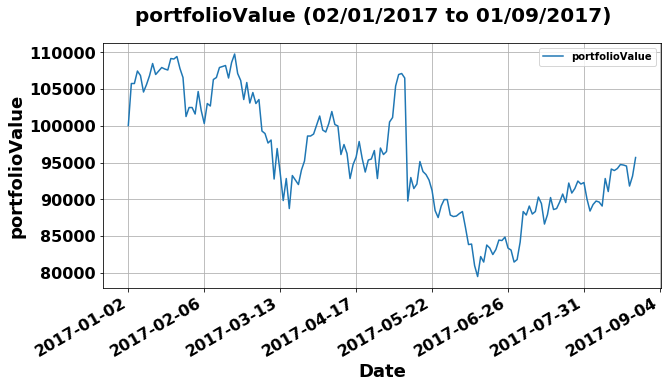

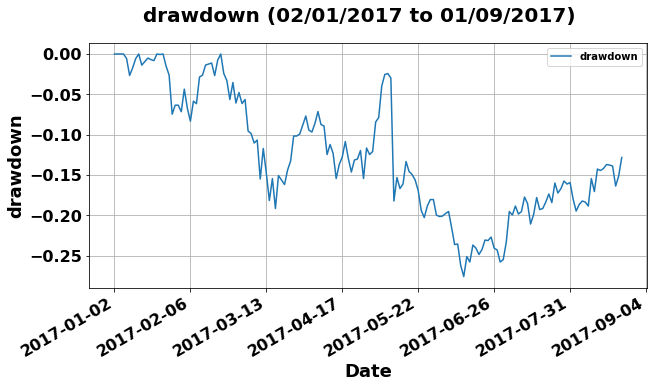

In [130]:
plotSeries(bt.history['buy-n-hold']['portfolioValue'])
plotSeries(bt.history['buy-n-hold']['drawdown'])

In [131]:
bt2 = Backtest(assets = ['PETR4'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')

bt2.simulate(verbose = 0, start = '2017', strategy = 'predicted', predicted = {'PETR4': df['PETR4_Close_trend']}, simulationName = 'predicted_trend')

Portfolio value at start: 100000.00 BRL
Portfolio value at end: 111807.58 BRL


(<matplotlib.figure.Figure at 0x7fd51c6e6b90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd51c7d3d10>)

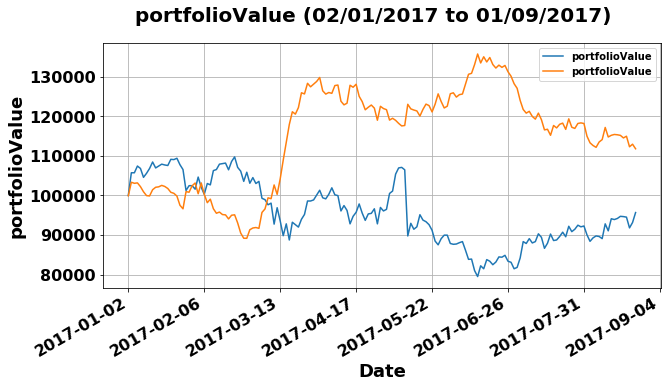

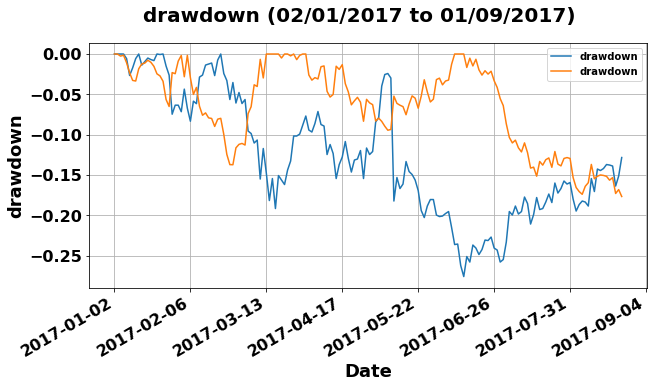

In [133]:
plotSeries([bt.history['buy-n-hold']['portfolioValue'], bt2.history['predicted_trend']['portfolioValue']])
plotSeries([bt.history['buy-n-hold']['drawdown'], bt2.history['predicted_trend']['drawdown']])

In [143]:
bt3 = Backtest(assets = ['PETR4'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')
bt3.simulate(verbose = 0, start = '2017', strategy = 'predicted', predicted = {'PETR4': df['PETR4_Close_predicted_MLPnorm']}, simulationName = 'predicted_mlp')

Portfolio value at start: 100000.00 BRL
Portfolio value at end: 93371.58 BRL


(<matplotlib.figure.Figure at 0x7fd517b9e310>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd517ade390>)

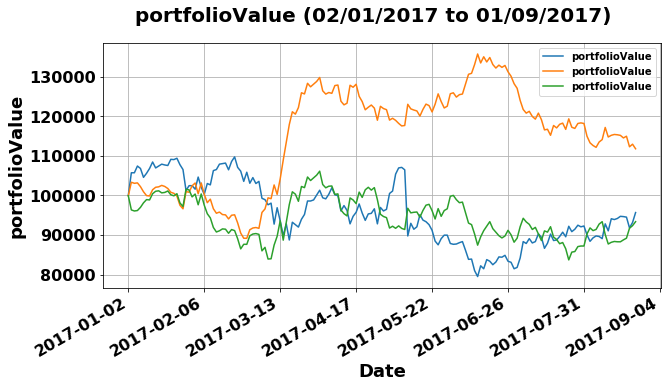

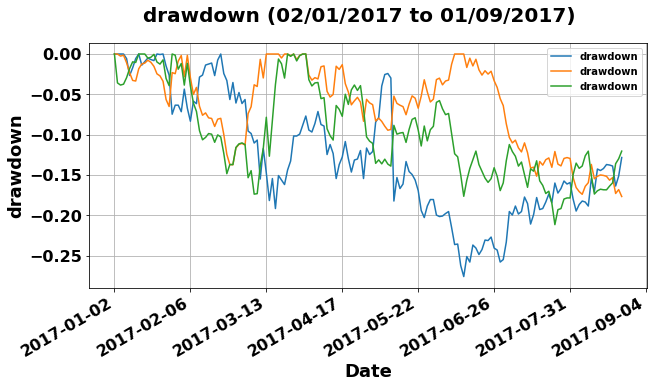

In [144]:
plotSeries([bt.history['buy-n-hold']['portfolioValue'], bt2.history['predicted_trend']['portfolioValue'], bt3.history['predicted_mlp']['portfolioValue']])
plotSeries([bt.history['buy-n-hold']['drawdown'], bt2.history['predicted_trend']['drawdown'], bt3.history['predicted_mlp']['drawdown']])

In [150]:
bt4 = Backtest(assets = ['PETR4'], dataPath = '../../../../../data/stocks/[asset]/diario/[asset].CSV')
bt4.simulate(verbose = 0, start = '2017', strategy = 'predicted', predicted = {'PETR4': df['PETR4_Close']}, simulationName = 'predicted_perfect')

Portfolio value at start: 100000.00 BRL
Portfolio value at end: 270813.79 BRL


(<matplotlib.figure.Figure at 0x7fd5179caed0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd517bdcf10>)

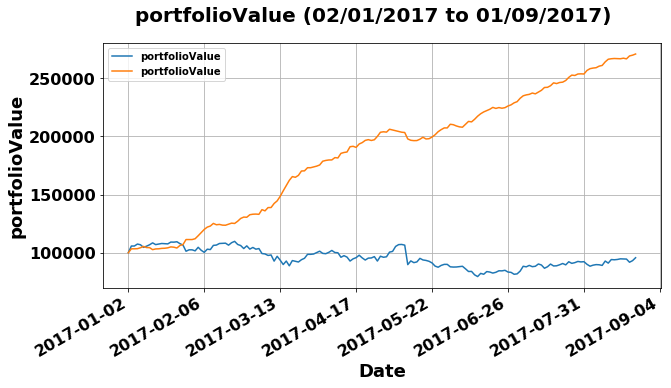

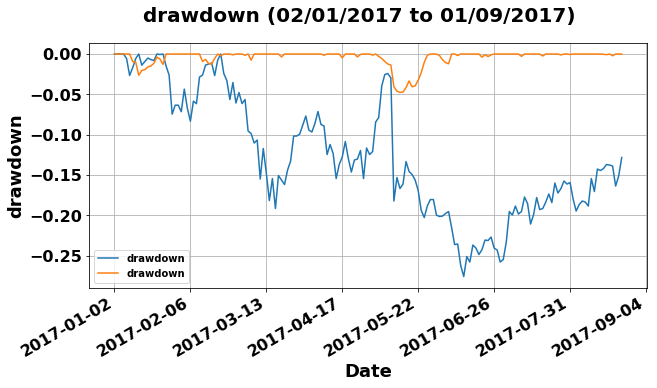

In [151]:
plotSeries([bt.history['buy-n-hold']['portfolioValue'], bt2.history['predicted_perfect']['portfolioValue'] ])
plotSeries([bt.history['buy-n-hold']['drawdown'], bt2.history['predicted_perfect']['drawdown']])